<a href="https://colab.research.google.com/github/fmhirwa/alu-MLI_Summative/blob/main/Chatbot_ALU_admissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
1. Tokenization + Preprocessing

In [1]:
# Import necessary classes from tokenizers and transformers
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast

# Step 1: Initialize the tokenizer with the BPE model and specify the unknown token
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

# Step 2: Create a trainer with special tokens you want to include
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

# Step 3: Set the pre-tokenizer to split text by whitespace
tokenizer.pre_tokenizer = Whitespace()

# Step 4: Define the list of file paths that the tokenizer will be trained on.
# Replace the file paths with your actual data files (make sure the file exists)
files = ["data/file1.txt"]

# Step 5: Train the tokenizer on the specified files using the trainer
tokenizer.train(files, trainer)

# Optionally, save the trained tokenizer to a JSON file for future re-use
tokenizer.save("tokenizer.json")

# Step 6: Load the trained tokenizer into the Transformers library as a fast tokenizer
# Option A: Directly from the tokenizer object
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

# Option B: Alternatively, load from the saved JSON file (uncomment the next line if needed)
# fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")

# Example usage: Encode some sample text using the fast tokenizer
sample_text = "Welcome to African Leadership University."
encoded = fast_tokenizer.encode(sample_text)

# Print the encoded token IDs directly (encoded is a list of token IDs)
print("Encoded IDs:", encoded)

# Alternatively, you can use encode_plus for more detailed output
encoded_plus = fast_tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
)
print("Encoded IDs using encode_plus:", encoded_plus["input_ids"])

# Print the tokenized output (tokens as strings)
print("Tokenized Output:", fast_tokenizer.tokenize(sample_text))


Encoded IDs: [42, 409, 139, 51, 115, 375, 251, 668, 12]
Encoded IDs using encode_plus: [42, 409, 139, 51, 115, 375, 251, 668, 12]
Tokenized Output: ['W', 'el', 'com', 'e', 'to', 'African', 'Leadership', 'University', '.']


In [ ]:
FIne Tuning

In [12]:
import os
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# Define function to load a text dataset for language modeling
def load_dataset(file_path, tokenizer, block_size=128):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size,
        overwrite_cache=True
    )

# Paths to your training and validation text files
train_file = "./data/ALU_train.txt"  # Contains your ALU info & conversational pairs
val_file = "./data/ALU_val.txt"

# Load the pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)

# If you want to use your custom tokenizer from token_code.py, you could load it like this:
# from transformers import PreTrainedTokenizerFast
# tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")

# Create datasets
train_dataset = load_dataset(train_file, tokenizer, block_size=128)
val_dataset = load_dataset(val_file, tokenizer, block_size=128) if os.path.exists(val_file) else None

# Create a data collator for language modeling (no masking for GPT-2)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define training hyperparameters using TrainingArguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned-alu",
    overwrite_output_dir=True,
    num_train_epochs= 15,                  # Adjust number of epochs as needed
    per_device_train_batch_size=2,       # Adjust batch size based on your hardware
    per_device_eval_batch_size=2,
    evaluation_strategy="steps" if val_dataset else "no",
    eval_steps=500,                      # Evaluation frequency (if using validation)
    logging_steps=100,
    save_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",                    # Set to "tensorboard" or "wandb" if desired
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start fine-tuning the model
trainer.train()

# Save the fine-tuned model and tokenizer for later use
model.save_pretrained("./gpt2-finetuned-alu")
tokenizer.save_pretrained("./gpt2-finetuned-alu")


/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1794 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


('./gpt2-finetuned-alu/tokenizer_config.json',
 './gpt2-finetuned-alu/special_tokens_map.json',
 './gpt2-finetuned-alu/vocab.json',
 './gpt2-finetuned-alu/merges.txt',
 './gpt2-finetuned-alu/added_tokens.json',
 './gpt2-finetuned-alu/tokenizer.json')

3. Evaluation

Prompt: What is African Leadership University?
Reference: African Leadership University (ALU) is committed to transforming higher education in Africa by developing ethical and entrepreneurial leaders. With campuses in Rwanda and Mauritius, ALU offers a unique learning experience that emphasizes real-world problem-solving and leadership development.
Generated: African Leadership (ALU) is committed to transforming higher education in Africa by developing leaders who are passionate about shaping Africa’s future. With campuses in Rwanda and Mauritius, ALU offers a unique learning experience that emphasizes leadership, problem-solving, and leadership development. Students begin their studies on the Kigali campus, offering experiential learning programs and internships.




What are the admissions requirements for admission?

: Applicants must have completed their final national secondary school examinations, including the BSc (Hons) in International Business and Trade (IBT), delivered on ti

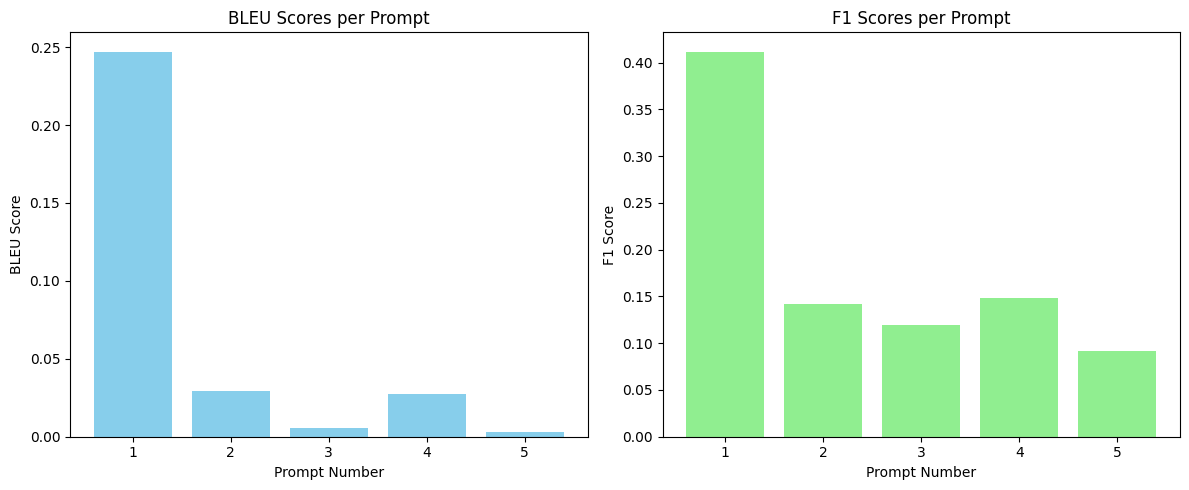

Average BLEU Score: 0.0625
Average F1 Score: 0.1826


In [15]:
import os
import re
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load fine-tuned GPT-2 model and tokenizer
model_dir = "./gpt2-finetuned-alu"
model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2TokenizerFast.from_pretrained(model_dir)
model.eval()

def compute_f1(prediction, reference):
    pred_tokens = prediction.split()
    ref_tokens = reference.split()
    common = set(pred_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Load evaluation prompts and references
with open("./data/ALU_val.txt", "r", encoding="utf-8") as f:
    eval_data = f.read()

pattern = r"\[Prompt \d+\]\s*Q:\s*(.*?)\s*A:\s*(.*?)\s*(?=\[Prompt \d+\]|$)"
matches = re.findall(pattern, eval_data, re.DOTALL)
prompts, references = zip(*[(m[0].strip(), m[1].strip()) for m in matches])

# Evaluate each prompt
bleu_scores, f1_scores, generated_responses = [], [], []
for prompt, ref in zip(prompts, references):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    attention_mask = torch.ones_like(input_ids)  # ✅ Added attention_mask
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=150,
            num_beams=5,
            no_repeat_ngram_size=2,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id  # ✅ Correct pad_token_id
        )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    generated_text = generated_text[len(prompt):].strip() if generated_text.startswith(prompt) else generated_text
    generated_responses.append(generated_text)

    smoothing_fn = SmoothingFunction().method1
    bleu = sentence_bleu([ref.split()], generated_text.split(), smoothing_function=smoothing_fn)
    f1 = compute_f1(generated_text, ref)
    bleu_scores.append(bleu)
    f1_scores.append(f1)

    print(f"Prompt: {prompt}\nReference: {ref}\nGenerated: {generated_text}\nBLEU: {bleu:.4f}, F1: {f1:.4f}\n" + "-"*50)

# Plot BLEU and F1 scores
x = range(1, len(prompts) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(x, bleu_scores, color='skyblue')
plt.xlabel("Prompt Number")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores per Prompt")

plt.subplot(1, 2, 2)
plt.bar(x, f1_scores, color='lightgreen')
plt.xlabel("Prompt Number")
plt.ylabel("F1 Score")
plt.title("F1 Scores per Prompt")

plt.tight_layout()
plt.show()

# Summary Metrics
print(f"Average BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Average F1 Score: {sum(f1_scores)/len(f1_scores):.4f}")


In [9]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00


In [11]:
import gradio as gr
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the fine-tuned GPT-2 model and tokenizer
model_dir = "./gpt2-finetuned-alu"
model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2TokenizerFast.from_pretrained(model_dir)
model.eval()

def generate_response(user_input):
    """
    Generate a response from the fine-tuned GPT-2 model based on user input.
    """
    # Encode the user input text
    input_ids = tokenizer.encode(user_input, return_tensors="pt")
    # Generate a response using beam search for quality output
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=150,
            num_beams=5,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
    # Decode the generated tokens to string and remove the prompt if repeated
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if generated_text.startswith(user_input):
        generated_text = generated_text[len(user_input):].strip()
    return generated_text

# Define the Gradio interface using the updated API
iface = gr.Interface(
    fn=generate_response,
    inputs=gr.Textbox(
        lines=2,
        placeholder="Enter your query about ALU (e.g., 'How do I apply to ALU?')"
    ),
    outputs=gr.Textbox(),
    title="ALU Chatbot",
    description=(
        "Welcome to the ALU Chatbot! Ask any questions about admissions, programs, "
        "and financial aid at African Leadership University. The chatbot uses a fine-tuned GPT-2 model "
        "to generate accurate and contextually relevant responses."
    ),
    theme="default"
)

# Launch the interface (set share=True if you need a public URL)
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ae98a17cf0a978d44c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
